# Clustering samples by environmental and functional data

## Overview

In this notebook samples are clustered both by their measured environmental data and the functional metaomics data in order to identify sample groups to be used for statistical analyses. The [01.process_data](01.process_data.ipynb) notebook should have been run prior to this to download and set up the required files.

In [1]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, os
from sklearn import cluster, manifold
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage,dendrogram,leaves_list,fcluster, set_link_color_palette

%config InlineBackend.figure_format = 'svg'
%matplotlib inline
plt.style.use('ggplot')

In [2]:
os.makedirs("figures", exist_ok=True)

In [3]:
def standardize(df):
    df = df.T
    for i in df.index:
        df.loc[i,:] = (df.loc[i,:]-df.loc[i].min()) / df.loc[i].max()
    return df.T

In [4]:
def paired_dendrograms(meta,fun,combined=pd.DataFrame(),metric="correlation",method="complete",wspace=0.75,x=8,y=4,color_threshold=None, t=1):
    # Set color threshold for dendrogram plot
    if color_threshold:
        if type(color_threshold)==int or type(color_threshold)==float: color_threshold = [color_threshold]*3
    else:
        color_threshold = [None,None,None]
    # Set up plot with either 2 or three subplots
    if combined.empty: 
        fig,axes = plt.subplots(ncols=2,nrows=1)
    else: 
        fig,axes = plt.subplots(ncols=3,nrows=1,figsize=(x,y))
    
    # Create a distance matrix from the metadata
    meta_dist = pdist(meta,metric=metric)
    # Create hierarchical clustering based on distance matrix
    meta_Z = linkage(meta_dist,method=method,metric=metric)
    
    # Create a distance matrix from the functional data
    fun_dist = pdist(fun,metric=metric)
    # Create hierarchical clustering based on distance matrix
    fun_Z = linkage(fun_dist,method=method,metric=metric)
    # Extract group numbers and create dictionary that groups sample names into corresponding groups
    fun_g = pd.DataFrame(fcluster(fun_Z,criterion="distance",t=t),index=fun.index).to_dict()[0]
    # Create list of labels for the functional dendrogram
    fun_labels = [x+" ("+str(fun_g[x])+")" for x in fun.index]
    
    # Create distance matrix for the combined data
    if not combined.empty: 
        com_dist = pdist(combined,metric=metric)
    
    # Plot dendrogram for metadata
    dendrogram(meta_Z, labels=meta.index,ax=axes[0], orientation="left", color_threshold=color_threshold[0]);
    axes[0].set_title("Metadata")
    
    # Plot dendrogram for functional data
    dendrogram(linkage(fun_dist,method=method,metric=metric),labels=fun_labels,ax=axes[1],orientation="right", color_threshold=color_threshold[1]);
    axes[1].set_title("Functional")
    
    # Plot dendrogram for combined data
    if not combined.empty: 
        dendrogram(linkage(com_dist,method=method,metric=metric),labels=combined.index,ax=axes[2],orientation="right", color_threshold=color_threshold[2]);
        axes[2].set_title("Combined")
    fig.subplots_adjust(wspace=wspace)
    return fun_g

In [5]:
def dist_dataframe(df,metric="correlation"):
    dist = pdist(df,metric=metric)
    return pd.DataFrame(squareform(dist),columns=df.index, index=df.index)

In [6]:
def plot_env_groupings(f,e,metric,method,threshold,order=False):
    d = pdist(f,metric=metric)
    Z = linkage(d,method=method)
    g = pd.DataFrame(fcluster(Z,criterion="distance",t=threshold),index=f.index).to_dict()[0]
    e["Sample"] = e.index
    e["Group"] = [g[x] for x in e.index]
    em = pd.melt(e,id_vars=["Sample","Group"])
    if order: x_order = order
    else: x_order = sorted(set(g.values()))
    ax = sns.catplot(data=em, col="variable", col_wrap=3, x="Group", order=x_order, 
                    y="value",errwidth=0.5,sharey=False,sharex=False,scale=0.5, height=2, aspect=1.5)
    ax.set_titles("{col_name}");
    for a in ax.axes: a.set_xticklabels(a.get_xticklabels(), rotation=90,fontsize=8);
    ax.fig.subplots_adjust(wspace=.15, hspace=1)
    return g

In [7]:
def get_cumulative_proportion(df, c=0.75):
    """
    Calculate cumulative proportion of transporters in a dataset
    
    Sorts transporters by their total sum over the season (high to low), then calculates the 
    cumulative proportion. Returns transporters that make up at least c cumulative proportion.
    """
    df_season_sum = df.groupby(level=0).sum().sum(axis=1).sort_values(ascending=False)
    tmp = df_season_sum.div(df_season_sum.sum())
    cumulative_sum = []
    for i,t in enumerate(tmp.index):
        cumulative_sum.append(tmp[0:i+1].sum())
    tmp = pd.DataFrame(tmp)
    tmp = tmp.assign(SUM=pd.Series(cumulative_sum, index=tmp.index))
    df = df.loc[tmp.loc[tmp.SUM<=c].index]
    return df

## Load the data

Load the environmental data.

In [8]:
metadata = pd.read_csv("data/LMO.time.series.metadata.csv", header=0, sep="\t", index_col=0)
metadata.rename(index=lambda x: str(x)[2:], inplace=True)
metavars = ["Temperature","Chla","Phosphate","Nitrate","Silicate","Ammonium"]

Load the metaomic data

For the metagenomes, transporters making up 95% of the cumulative proportion over the season were used for the functional clustering.

In [9]:
mg_trans = pd.read_table("results/mg/all_trans.tpm.tsv", header=0, sep="\t", index_col=0)
mg_trans = mg_trans.loc[mg_trans.sum(axis=1)>0]
mg_trans = get_cumulative_proportion(mg_trans,c=0.95)
print(len(mg_trans))

91


The metatranscriptomic data proved to be more unstable, probably due to sparser sampling and/or different prefiltering applied during sampling. Here all transporters with a sum >0 over the season were used.

In [10]:
mt_trans = pd.read_table("results/mt/all_trans.tpm.tsv", header=0, sep="\t", index_col=0)
mt_trans = mt_trans.loc[mt_trans.sum(axis=1)>0]
mt_trans = get_cumulative_proportion(mt_trans,c=1)
print(len(mt_trans))

240


## Make data conform

Make metadata and functional data dataframes match up in term of samples.

In [11]:
mg_metadata = metadata.loc[mg_trans.columns,metavars]
mg_transm = mg_trans[mg_metadata.index].T

The metatranscriptomic time-series are missing values for TotalN for 5 samples and 2 of these samples have no metadata measured.

In [12]:
mt_metadata = metadata.loc[mt_trans.columns, metavars]
mt_metadata.drop(["140916","141013"],inplace=True)
mt_transm = mt_trans.T.loc[set(mt_metadata.index).intersection(mt_trans.columns)]

## Standardize data

Standardize the data to zero mean and standard deviation of 1.

In [13]:
mg_metadata_stand = standardize(mg_metadata)
mg_transm_stand = standardize(mg_transm)

In [14]:
mt_metadata_stand = standardize(mt_metadata)
mt_transm_stand = standardize(mt_transm)

Combine the standardized dataframes per dataset.

In [15]:
mg_combined = pd.concat([mg_transm_stand,mg_metadata_stand],axis=1)

In [16]:
mt_combined = pd.concat([mt_transm_stand,mt_metadata_stand],axis=1)

## Dendrograms

### Metagenomes

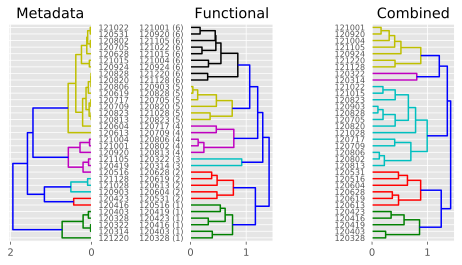

In [17]:
mg_fun_g = paired_dendrograms(mg_metadata_stand, mg_transm_stand, mg_combined, method="complete", metric="correlation", wspace=1.2,t=1,color_threshold=1)

Set names for sample groups:

In [18]:
mg_group_names_list = ['early-spring', 'spring', 'early-summer', 'summer1', 'summer2', 'fall']
mg_group_names = {3: 'early-spring', 1: 'spring', 2: 'early-summer', 4: 'summer1', 5: 'summer2', 6: 'fall'}
mg_group_name_df = pd.merge(pd.DataFrame(mg_fun_g, index=["group"]).T, pd.DataFrame(mg_group_names, index=["name"]).T, left_on="group", right_index=True)
mg_group_name_df.head()

,group,name
120314,3,early-spring
120322,3,early-spring
120328,1,spring
120403,1,spring
120416,1,spring


In [19]:
mg_groupdict = {}
for g in mg_group_names.values():
    mg_groupdict[g] = list(mg_group_name_df.loc[mg_group_name_df["name"]==g].index)
mg_groupdict

{'early-spring': ['120314', '120322'],
 'spring': ['120328', '120403', '120416', '120419', '120423', '120516'],
 'early-summer': ['120531', '120604', '120613', '120619', '120628'],
 'summer1': ['120709', '120717', '120802', '120806', '120813'],
 'summer2': ['120705', '120820', '120823', '120828', '120903', '121028'],
 'fall': ['120920',
  '120924',
  '121001',
  '121004',
  '121015',
  '121022',
  '121105',
  '121128',
  '121220']}

Plot the environmental data for the defined sample groups.

In [20]:
mg_group_env = pd.merge(mg_metadata, mg_group_name_df, left_index=True, right_index=True).reset_index()
mg_group_env.head()

,index,Temperature,Chla,Phosphate,Nitrate,Silicate,Ammonium,group,name
0,120314,0.010870,0.045131,0.693878,0.960366,0.055435,0.113565,3,early-spring
1,120322,0.000000,0.213777,0.721088,0.841463,0.050543,0.176656,3,early-spring
2,120328,0.038043,0.225653,0.911565,0.704268,0.204348,0.208202,1,spring
3,120403,0.005435,0.543943,0.979592,0.722561,0.101087,0.290221,1,spring
4,120416,0.054348,0.482185,0.455782,0.137195,0.000000,0.145110,1,spring


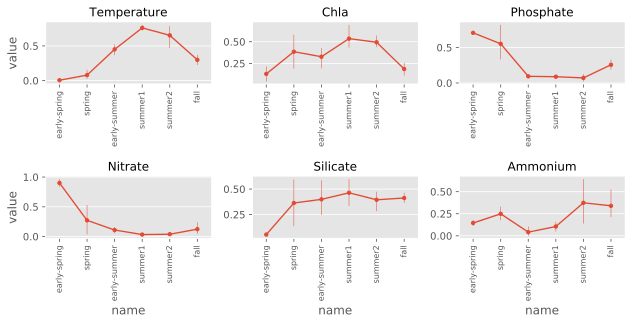

In [21]:
mg_group_envm = pd.melt(mg_group_env,id_vars=["index","group", "name"])
ax = sns.catplot(kind="point", data=mg_group_envm, col="variable", col_wrap=3, x="name", 
                    order=mg_group_names_list,
                    y="value", sharey=False, errwidth=0.5, scale=0.5, sharex=False, height=2, aspect=1.5)
ax.set_titles("{col_name}");
for a in ax.axes: a.set_xticklabels(a.get_xticklabels(), rotation=90,fontsize=8);
ax.fig.subplots_adjust(wspace=.25, hspace=1.5)

Re-plot dendrogram with updated group names.

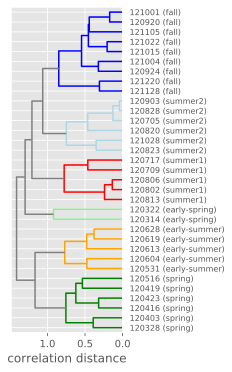

In [22]:
mg_map = {}
for i in mg_transm.index:
    try: mg_map[i] = mg_group_name_df.loc[i,"name"]
    except KeyError: mg_map[i] = "NA"
mg_grouped_stand = mg_transm.copy()
mg_grouped_stand = mg_grouped_stand.rename(index=lambda x: "{} ({})".format(x,mg_map[x]))
d = pdist(mg_grouped_stand,metric="correlation")
Z = linkage(d,method="complete")
plt.figure(figsize=(2,6))
set_link_color_palette(['green','orange','lightgreen','red','lightblue','blue'])
dendrogram(Z, orientation="left", labels=mg_grouped_stand.index, color_threshold=1, above_threshold_color="grey")
plt.xlabel("correlation distance");
plt.savefig("results/Figure2.svg", bbox_inches="tight")

Write sample groups to file.

In [23]:
mg_group_name_df.drop("group", axis=1).to_csv("results/mg/samplegroups.tab", sep="\t")

### Metatranscriptomes

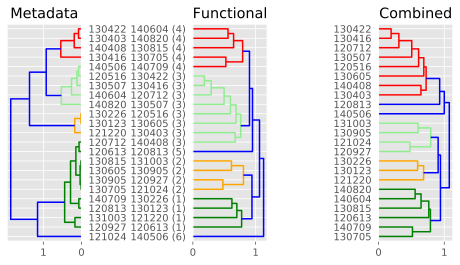

In [24]:
mt_fun_g = paired_dendrograms(mt_metadata_stand, mt_transm_stand, mt_combined, method="complete", metric="correlation", wspace=1.5,t=0.9, color_threshold=0.9)

The overall picture is that there are 4 main sample groups:

- spring
  - 130416, 130422, 120712, 130507, 120516, 130605, 140408, 130605, 140408, 130403
- summer
  - 140604, 140820, 130815, 140709, 130705
- fall
  - 130905, 131003, 121024, 120927
- winter
  - 130226, 130123, 121220

Outliers to this seasonal pattern were:
- 140506 which clustered separately from the rest in the functional data but as a typical early-summer sample in the metadata
- 120613 which clustered with the winter samples in the functional data
- 120813 which clustered at the root of the spring and summer samples

Nevertheless, the overall pattern was one where the fall and winter sample groups appeared more similar *wrt* the spring and summer sample groups.

In [25]:
mt_group_names_list = ['spring', 'summer', 'fall', 'winter']
mt_group_names = {1: 'winter', 2: 'fall', 3: 'spring', 4: 'summer', 5: 'summer'}
mt_group_name_df = pd.merge(pd.DataFrame(mt_fun_g, index=["group"]).T, pd.DataFrame(mt_group_names, index=["name"]).T, left_on="group", right_index=True)
# Remove the 120613 sample
mt_group_name_df.drop("120613", inplace=True)
mt_group_name_df.head()

,group,name
120516,3,spring
120712,3,spring
130403,3,spring
130416,3,spring
130422,3,spring


In [26]:
mt_groupdict = {}
for g in mt_group_names.values():
    mt_groupdict[g] = list(mt_group_name_df.loc[mt_group_name_df["name"]==g].index)
mt_groupdict

{'winter': ['121220', '130123', '130226'],
 'fall': ['120927', '121024', '130905', '131003'],
 'spring': ['120516',
  '120712',
  '130403',
  '130416',
  '130422',
  '130507',
  '130605',
  '140408'],
 'summer': ['120813', '130705', '130815', '140604', '140709', '140820']}

In [27]:
mt_group_env = pd.merge(mt_metadata, mt_group_name_df, left_index=True, right_index=True).reset_index()
mt_group_env.head()

,index,Temperature,Chla,Phosphate,Nitrate,Silicate,Ammonium,group,name
0,120516,0.291209,0.233471,0.819672,0.020942,0.578567,0.153333,3,spring
1,120712,0.703297,0.301653,0.295082,0.044503,0.217102,0.000000,3,spring
2,120813,0.879121,0.793388,0.295082,0.047120,0.404220,0.136667,5,summer
3,120927,0.538462,0.353306,0.327869,0.005236,0.222099,0.340000,2,fall
4,121024,0.401099,0.398760,0.377049,0.015707,0.179900,1.000000,2,fall


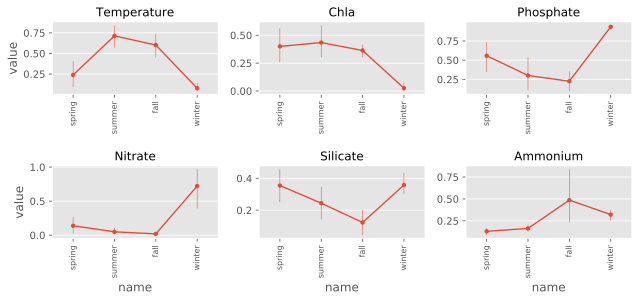

In [28]:
mt_group_envm = pd.melt(mt_group_env,id_vars=["index","group", "name"])
ax = sns.catplot(kind="point", data=mt_group_envm, col="variable", col_wrap=3, x="name", 
                    order=mt_group_names_list,
                    y="value",errwidth=0.5,sharey=False,sharex=False,scale=0.5, height=2, aspect=1.5)
ax.set_titles("{col_name}");
for a in ax.axes: a.set_xticklabels(a.get_xticklabels(), rotation=90,fontsize=8);
ax.fig.subplots_adjust(wspace=.25, hspace=1)

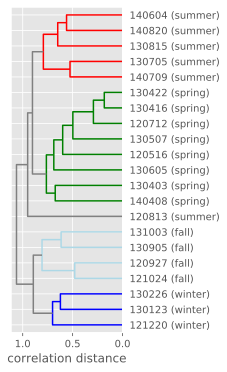

In [29]:
mt_map = {}
for i in mt_transm.index:
    try: 
        mt_map[i] = mt_group_name_df.loc[i,"name"]
    except KeyError: 
        continue
mt_grouped_stand = mt_transm.loc[mt_map.keys()]
mt_grouped_stand = mt_grouped_stand.rename(index=lambda x: "{} ({})".format(x,mt_map[x]))
d = pdist(mt_grouped_stand,metric="correlation")
Z = linkage(d,method="complete")
plt.figure(figsize=(2,6))
set_link_color_palette(['blue','lightblue','green', 'red'])
dendrogram(Z, orientation="left", labels=mt_grouped_stand.index, color_threshold=0.85, above_threshold_color="grey")
plt.xlabel("correlation distance");

In [30]:
mt_group_name_df.drop("group", axis=1).to_csv("results/mt/samplegroups.tab", sep="\t")